In [1]:
# Install dependencies if needed
# !pip install scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# -----------------------------
# 1. Load dataset
# -----------------------------
df = pd.read_csv("claude.csv")

# Severity mapping
severity_mapping = {
    "No Injury": "None",
    "Possible Injury": "Minor",
    "Non Incapacitating Injury": "Minor",
    "Suspected Minor Injury": "Minor",
    "Incapacitating Injury": "Severe",
    "Suspected Serious Injury": "Severe",
    "Fatal": "Severe"
}
df["severity_class"] = df["injury_severity"].map(severity_mapping)

# Binary target: Severe = 1, else 0
df["target"] = (df["severity_class"] == "Severe").astype(int)

# -----------------------------
# 2. Feature selection
# -----------------------------
# Drop columns we shouldn't use (like IDs, raw severity, target, etc.)
drop_cols = ["injury_severity", "severity_class", "target"]
feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols]
y = df["target"]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# -----------------------------
# 3. Identify categorical vs numeric
# -----------------------------
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

# Preprocess: OneHot for categorical, passthrough numeric
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)

# -----------------------------
# 4. Logistic Regression
# -----------------------------
log_reg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=500))
])

log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Extract odds ratios
ohe = log_reg.named_steps["preprocessor"].named_transformers_["cat"]
cat_features = ohe.get_feature_names_out(cat_cols)
all_features = np.concatenate([cat_features, num_cols])

coefs = log_reg.named_steps["classifier"].coef_[0]
odds_ratios = pd.DataFrame({
    "feature": all_features,
    "odds_ratio": np.exp(coefs)
}).sort_values("odds_ratio", ascending=False)

# Plot odds ratios (top 15)
plt.figure(figsize=(8,6))
sns.barplot(data=odds_ratios.head(15), x="odds_ratio", y="feature", palette="viridis")
plt.title("Top 15 Logistic Regression Odds Ratios (Severe Crash Likelihood)")
plt.xlabel("Odds Ratio (log scale)")
plt.xscale("log")
plt.tight_layout()
plt.show()

# -----------------------------
# 5. Random Forest
# -----------------------------
rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=300, random_state=42))
])

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Feature importances
importances = rf.named_steps["classifier"].feature_importances_
feat_importances = pd.DataFrame({
    "feature": all_features,
    "importance": importances
}).sort_values("importance", ascending=False)

# Plot top 15
plt.figure(figsize=(8,6))
sns.barplot(data=feat_importances.head(15), x="importance", y="feature", palette="magma")
plt.title("Top 15 Random Forest Feature Importances")
plt.tight_layout()
plt.show()

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# -----------------------------
# 6. PCA Visualization
# -----------------------------

# Encode categorical features (same as before, but output array for PCA)
X_encoded = preprocessor.fit_transform(X)

# Scale features
X_scaled = StandardScaler(with_mean=False).fit_transform(X_encoded)

# PCA to 2 components
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Build plotting DataFrame
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["severity_ratio"] = y  # 1 = severe, 0 = not severe

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df, 
    x="PC1", y="PC2",
    hue="severity_ratio", 
    palette={0:"skyblue", 1:"darkred"}, 
    alpha=0.6
)
plt.title("PCA of Intersections by Severity Class")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.legend(title="Severity")
plt.tight_layout()
plt.show()

/Users/joshuadollison/opt/anaconda3/envs/py312/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15081
           1       0.33      0.01      0.02       311

    accuracy                           0.98     15392
   macro avg       0.66      0.50      0.50     15392
weighted avg       0.97      0.98      0.97     15392



/var/folders/1h/6fq3hhfs7qlg8zyscb77k7l80000gn/T/ipykernel_147/1381180029.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=odds_ratios.head(15), x="odds_ratio", y="feature", palette="viridis")


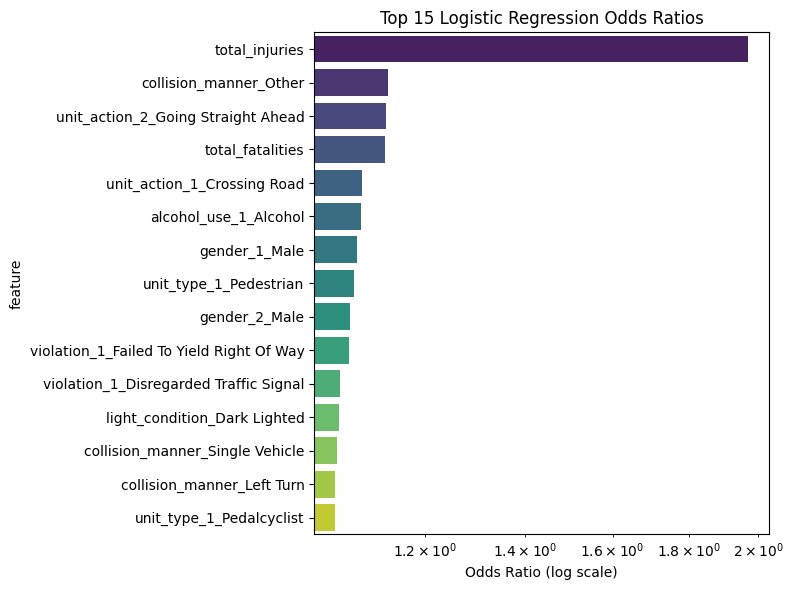

Random Forest Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15081
           1       1.00      0.02      0.03       311

    accuracy                           0.98     15392
   macro avg       0.99      0.51      0.51     15392
weighted avg       0.98      0.98      0.97     15392



/var/folders/1h/6fq3hhfs7qlg8zyscb77k7l80000gn/T/ipykernel_147/1381180029.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_importances.head(15), x="importance", y="feature", palette="magma")


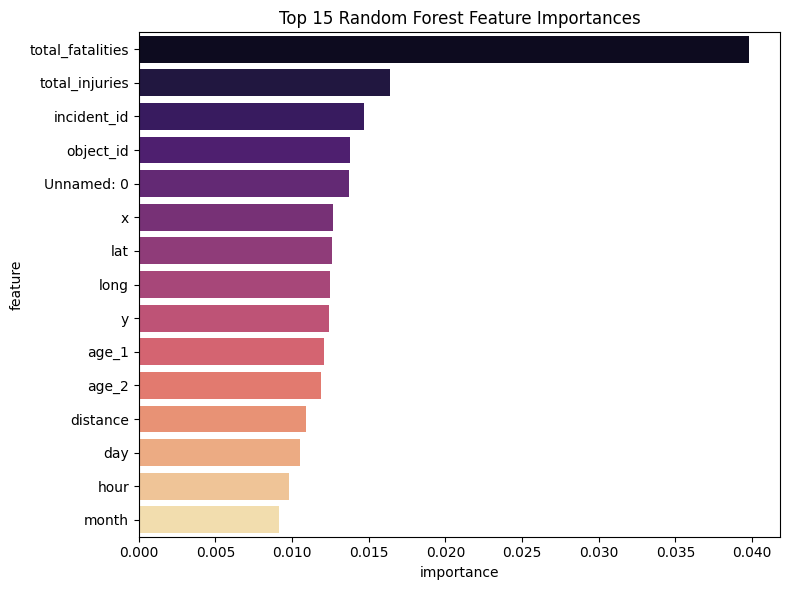

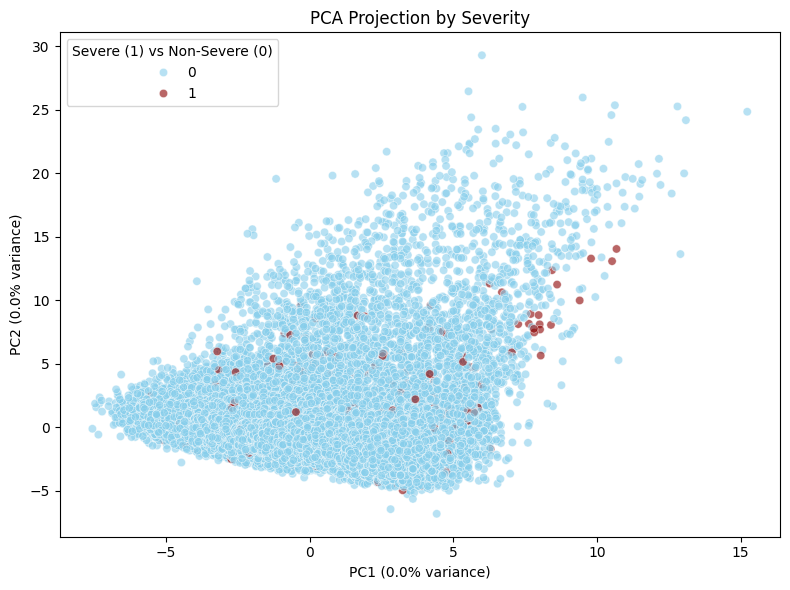

In [2]:
# Install dependencies if needed
# !pip install scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

# -----------------------------
# 1. Load dataset
# -----------------------------
df = pd.read_csv("claude.csv")

# Map severities
severity_mapping = {
    "No Injury": "None",
    "Possible Injury": "Minor",
    "Non Incapacitating Injury": "Minor",
    "Suspected Minor Injury": "Minor",
    "Incapacitating Injury": "Severe",
    "Suspected Serious Injury": "Severe",
    "Fatal": "Severe"
}
df["severity_class"] = df["injury_severity"].map(severity_mapping)

# Binary target
df["target"] = (df["severity_class"] == "Severe").astype(int)

# -----------------------------
# 2. Features & target
# -----------------------------
drop_cols = ["injury_severity", "severity_class", "target"]
feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols]
y = df["target"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# -----------------------------
# 3. Preprocessor with Imputation
# -----------------------------
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median"))
        ]), num_cols)
    ]
)

# -----------------------------
# 4. Logistic Regression
# -----------------------------
log_reg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=500))
])

log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))

# Extract odds ratios
ohe = log_reg.named_steps["preprocessor"].named_transformers_["cat"].named_steps["encoder"]
cat_features = ohe.get_feature_names_out(cat_cols)
all_features = np.concatenate([cat_features, num_cols])

coefs = log_reg.named_steps["classifier"].coef_[0]
odds_ratios = pd.DataFrame({
    "feature": all_features,
    "odds_ratio": np.exp(coefs)
}).sort_values("odds_ratio", ascending=False)

# Plot odds ratios
plt.figure(figsize=(8,6))
sns.barplot(data=odds_ratios.head(15), x="odds_ratio", y="feature", palette="viridis")
plt.title("Top 15 Logistic Regression Odds Ratios")
plt.xlabel("Odds Ratio (log scale)")
plt.xscale("log")
plt.tight_layout()
plt.show()

# -----------------------------
# 5. Random Forest
# -----------------------------
rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=300, random_state=42))
])

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))

# Feature importances
importances = rf.named_steps["classifier"].feature_importances_
feat_importances = pd.DataFrame({
    "feature": all_features,
    "importance": importances
}).sort_values("importance", ascending=False)

# Plot
plt.figure(figsize=(8,6))
sns.barplot(data=feat_importances.head(15), x="importance", y="feature", palette="magma")
plt.title("Top 15 Random Forest Feature Importances")
plt.tight_layout()
plt.show()

# -----------------------------
# 6. PCA Visualization
# -----------------------------
# Full encoded + imputed data
X_encoded = preprocessor.fit_transform(X)

# Scale
X_scaled = StandardScaler(with_mean=False).fit_transform(X_encoded)

# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["severity"] = y

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df, x="PC1", y="PC2",
    hue="severity", palette={0:"skyblue", 1:"darkred"},
    alpha=0.6
)
plt.title("PCA Projection by Severity")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.legend(title="Severe (1) vs Non-Severe (0)")
plt.tight_layout()
plt.show()

### Correction 3
Tightly bound features <br/>
SMOTE

/Users/joshuadollison/opt/anaconda3/envs/py312/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/1h/6fq3hhfs7qlg8zyscb77k7l80000gn/T/ipykernel_147/3314635426.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=odds_ratios.head(15), x="odds_ratio", y="feature", palette="viridis")


Logistic Regression Report (Balanced + SMOTE):
              precision    recall  f1-score   support

           0       0.99      0.82      0.90     15081
           1       0.07      0.63      0.12       311

    accuracy                           0.81     15392
   macro avg       0.53      0.72      0.51     15392
weighted avg       0.97      0.81      0.88     15392



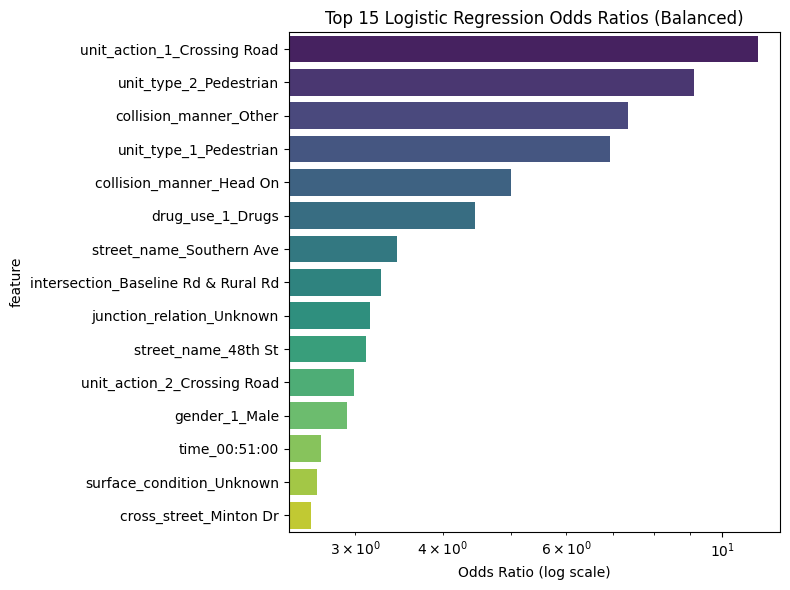

Random Forest Report (Balanced + SMOTE):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15081
           1       0.80      0.01      0.03       311

    accuracy                           0.98     15392
   macro avg       0.89      0.51      0.51     15392
weighted avg       0.98      0.98      0.97     15392



/var/folders/1h/6fq3hhfs7qlg8zyscb77k7l80000gn/T/ipykernel_147/3314635426.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_importances.head(15), x="importance", y="feature", palette="magma")


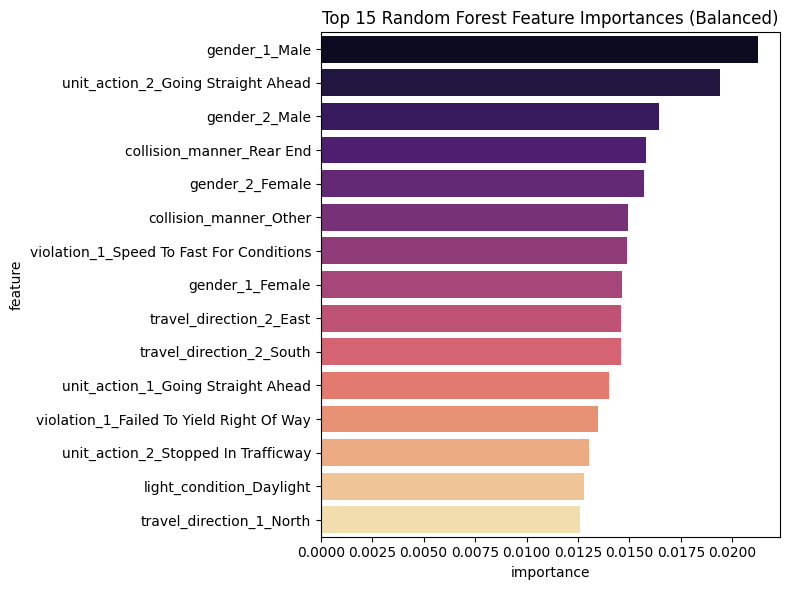

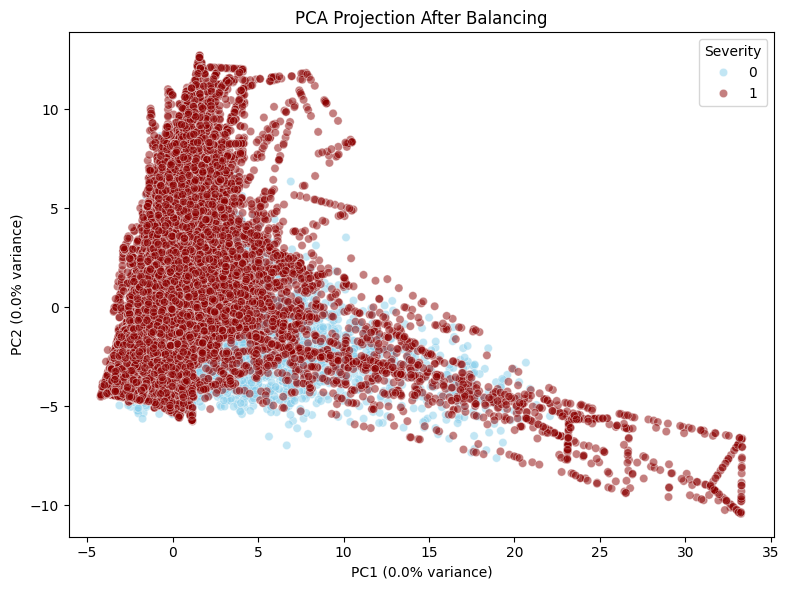

In [3]:
# !pip install imbalanced-learn scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

# -----------------------------
# 1. Load dataset
# -----------------------------
df = pd.read_csv("claude.csv")

severity_mapping = {
    "No Injury": "None",
    "Possible Injury": "Minor",
    "Non Incapacitating Injury": "Minor",
    "Suspected Minor Injury": "Minor",
    "Incapacitating Injury": "Severe",
    "Suspected Serious Injury": "Severe",
    "Fatal": "Severe"
}
df["severity_class"] = df["injury_severity"].map(severity_mapping)
df["target"] = (df["severity_class"] == "Severe").astype(int)

# -----------------------------
# 2. Feature selection (drop outcome-like fields)
# -----------------------------
drop_cols = [
    "injury_severity", "severity_class", "target",
    "total_injuries", "total_fatalities", "incident_id", "object_id", "Unnamed: 0"
]
feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols]
y = df["target"]

# -----------------------------
# 3. Train/Test split + SMOTE
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median"))
        ]), num_cols)
    ]
)

# Encode + SMOTE on training data only
X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_enc, y_train)

# Get feature names
ohe = preprocessor.named_transformers_["cat"].named_steps["encoder"]
cat_features = ohe.get_feature_names_out(cat_cols)
all_features = np.concatenate([cat_features, num_cols])

# -----------------------------
# 4. Logistic Regression (Balanced)
# -----------------------------
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")
log_reg.fit(X_train_bal, y_train_bal)
y_pred_lr = log_reg.predict(X_test_enc)

print("Logistic Regression Report (Balanced + SMOTE):")
print(classification_report(y_test, y_pred_lr))

coefs = log_reg.coef_[0]
odds_ratios = pd.DataFrame({
    "feature": all_features,
    "odds_ratio": np.exp(coefs)
}).sort_values("odds_ratio", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=odds_ratios.head(15), x="odds_ratio", y="feature", palette="viridis")
plt.title("Top 15 Logistic Regression Odds Ratios (Balanced)")
plt.xlabel("Odds Ratio (log scale)")
plt.xscale("log")
plt.tight_layout()
plt.show()

# -----------------------------
# 5. Random Forest (Balanced)
# -----------------------------
rf = RandomForestClassifier(
    n_estimators=300, random_state=42, class_weight="balanced"
)
rf.fit(X_train_bal, y_train_bal)
y_pred_rf = rf.predict(X_test_enc)

print("Random Forest Report (Balanced + SMOTE):")
print(classification_report(y_test, y_pred_rf))

importances = rf.feature_importances_
feat_importances = pd.DataFrame({
    "feature": all_features,
    "importance": importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=feat_importances.head(15), x="importance", y="feature", palette="magma")
plt.title("Top 15 Random Forest Feature Importances (Balanced)")
plt.tight_layout()
plt.show()

# -----------------------------
# 6. PCA Visualization (Balanced)
# -----------------------------
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X_train_bal)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["severity"] = y_train_bal

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df, x="PC1", y="PC2",
    hue="severity", palette={0:"skyblue", 1:"darkred"}, alpha=0.5
)
plt.title("PCA Projection After Balancing")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.legend(title="Severity")
plt.tight_layout()
plt.show()

### Better focus on intersection characteristics

In [5]:
# Map severity
severity_mapping = {
    "No Injury": "None",
    "Possible Injury": "Minor",
    "Non Incapacitating Injury": "Minor",
    "Suspected Minor Injury": "Minor",
    "Incapacitating Injury": "Severe",
    "Suspected Serious Injury": "Severe",
    "Fatal": "Severe"
}
df["severity_class"] = df["injury_severity"].map(severity_mapping)
df["is_severe"] = (df["severity_class"] == "Severe").astype(int)

# Helper flags using both unit_1 and unit_2
def flag_any(row, cols, keyword):
    return int(any(str(row[c]).lower().find(keyword.lower()) >= 0 for c in cols if pd.notna(row[c])))

df["alcohol_flag"] = df.apply(lambda r: flag_any(r, ["alcohol_use_1", "alcohol_use_2"], "yes"), axis=1)
df["drug_flag"]    = df.apply(lambda r: flag_any(r, ["drug_use_1", "drug_use_2"], "yes"), axis=1)
df["ped_flag"]     = df.apply(lambda r: flag_any(r, ["unit_type_1", "unit_type_2"], "pedestrian"), axis=1)
df["bike_flag"]    = df.apply(lambda r: flag_any(r, ["unit_type_1", "unit_type_2"], "pedalcyclist"), axis=1)
df["speed_flag"]   = df.apply(lambda r: flag_any(r, ["violation_1", "violation_2"], "speed"), axis=1)

# Night flag
df["night_flag"] = df["light_condition"].astype(str).str.contains("Dark", case=False, na=False).astype(int)

# Average driver age (take mean of available ages for unit 1 & 2)
df["avg_age_event"] = df[["age_1", "age_2"]].mean(axis=1)

# Aggregate to intersections
intersection_stats = df.groupby(["street_name", "cross_street"]).agg(
    accident_count = ("injury_severity", "count"),
    severe_count   = ("is_severe", "sum"),
    alcohol_pct    = ("alcohol_flag", "mean"),
    drug_pct       = ("drug_flag", "mean"),
    ped_pct        = ("ped_flag", "mean"),
    bike_pct       = ("bike_flag", "mean"),
    night_pct      = ("night_flag", "mean"),
    speed_pct      = ("speed_flag", "mean"),
    avg_age        = ("avg_age_event", "mean")
).reset_index()

# Severity ratio
intersection_stats["severity_ratio"] = (
    intersection_stats["severe_count"] / intersection_stats["accident_count"]
)

# Preview top intersections
print(intersection_stats.sort_values("accident_count", ascending=False).head(10))

        street_name     cross_street  accident_count  severe_count  \
2270       Price Rd      Broadway Rd             435             3   
2967  University Dr         Rural Rd             418             4   
438     Baseline Rd        Kyrene Rd             408             9   
2085       Mill Ave     Southern Ave             378             3   
2598       Rural Rd     Southern Ave             377             4   
2804   Southern Ave         Rural Rd             370            14   
2558       Rural Rd      Broadway Rd             362             7   
1899  McClintock Dr  Rio Salado Pkwy             361             3   
573     Broadway Rd         Price Rd             360             5   
579     Broadway Rd         Rural Rd             355             5   

      alcohol_pct  drug_pct   ped_pct  bike_pct  night_pct  speed_pct  \
2270          0.0       0.0  0.006897  0.022989   0.262069   0.314943   
2967          0.0       0.0  0.023923  0.074163   0.342105   0.265550   
438       

/Users/joshuadollison/opt/anaconda3/envs/py312/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/1h/6fq3hhfs7qlg8zyscb77k7l80000gn/T/ipykernel_147/1106446698.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=odds_ratios.head(15), x="odds_ratio", y="feature", palette="viridis")


Logistic Regression Report (Crash-Level + SMOTE):
              precision    recall  f1-score   support

           0       0.99      0.82      0.90     15081
           1       0.07      0.63      0.12       311

    accuracy                           0.81     15392
   macro avg       0.53      0.72      0.51     15392
weighted avg       0.97      0.81      0.88     15392



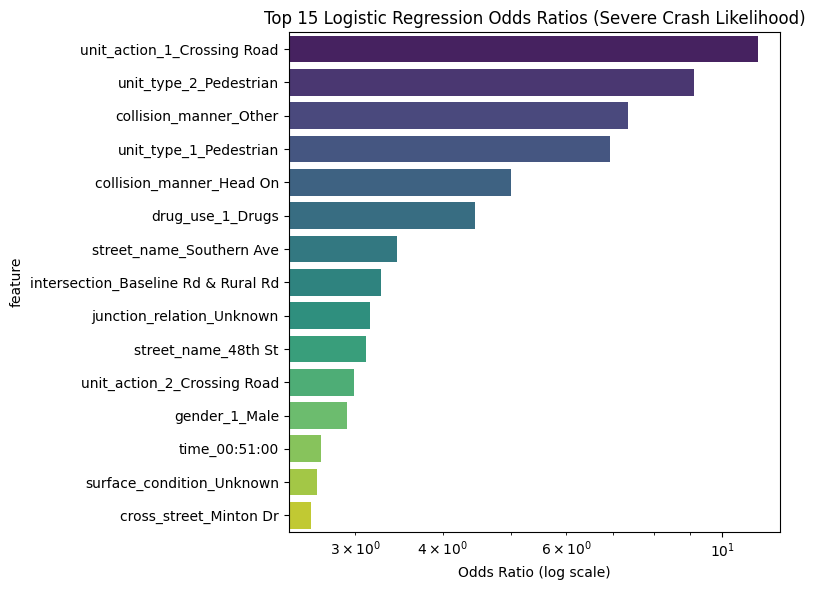

Random Forest Report (Crash-Level + SMOTE):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15081
           1       0.80      0.01      0.03       311

    accuracy                           0.98     15392
   macro avg       0.89      0.51      0.51     15392
weighted avg       0.98      0.98      0.97     15392



/var/folders/1h/6fq3hhfs7qlg8zyscb77k7l80000gn/T/ipykernel_147/1106446698.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_importances.head(15), x="importance", y="feature", palette="magma")


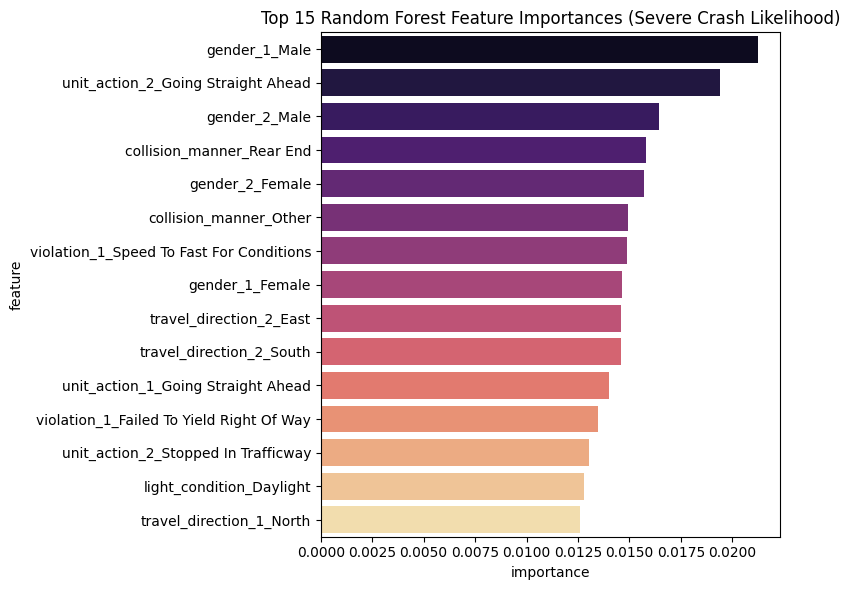

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# -----------------------------
# 1. Load dataset
# -----------------------------
df = pd.read_csv("claude.csv")

# Severity mapping
severity_mapping = {
    "No Injury": "None",
    "Possible Injury": "Minor",
    "Non Incapacitating Injury": "Minor",
    "Suspected Minor Injury": "Minor",
    "Incapacitating Injury": "Severe",
    "Suspected Serious Injury": "Severe",
    "Fatal": "Severe"
}
df["severity_class"] = df["injury_severity"].map(severity_mapping)
df["target"] = (df["severity_class"] == "Severe").astype(int)

# -----------------------------
# 2. Features / target
# -----------------------------
drop_cols = ["injury_severity", "severity_class", "target", 
             "total_injuries", "total_fatalities", "incident_id", 
             "object_id", "Unnamed: 0"]

feature_cols = [c for c in df.columns if c not in drop_cols]
X = df[feature_cols]
y = df["target"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# -----------------------------
# 3. Preprocessing + SMOTE
# -----------------------------
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median"))
        ]), num_cols)
    ]
)

# Encode train/test
X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test)

# Apply SMOTE to training set
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_enc, y_train)

# Feature names
ohe = preprocessor.named_transformers_["cat"].named_steps["encoder"]
cat_features = ohe.get_feature_names_out(cat_cols)
all_features = np.concatenate([cat_features, num_cols])

# -----------------------------
# 4. Logistic Regression
# -----------------------------
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")
log_reg.fit(X_train_bal, y_train_bal)
y_pred_lr = log_reg.predict(X_test_enc)

print("Logistic Regression Report (Crash-Level + SMOTE):")
print(classification_report(y_test, y_pred_lr))

coefs = log_reg.coef_[0]
odds_ratios = pd.DataFrame({
    "feature": all_features,
    "odds_ratio": np.exp(coefs)
}).sort_values("odds_ratio", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=odds_ratios.head(15), x="odds_ratio", y="feature", palette="viridis")
plt.title("Top 15 Logistic Regression Odds Ratios (Severe Crash Likelihood)")
plt.xlabel("Odds Ratio (log scale)")
plt.xscale("log")
plt.tight_layout()
plt.show()

# -----------------------------
# 5. Random Forest
# -----------------------------
rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced")
rf.fit(X_train_bal, y_train_bal)
y_pred_rf = rf.predict(X_test_enc)

print("Random Forest Report (Crash-Level + SMOTE):")
print(classification_report(y_test, y_pred_rf))

importances = rf.feature_importances_
feat_importances = pd.DataFrame({
    "feature": all_features,
    "importance": importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=feat_importances.head(15), x="importance", y="feature", palette="magma")
plt.title("Top 15 Random Forest Feature Importances (Severe Crash Likelihood)")
plt.tight_layout()
plt.show()